In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import trimesh


In [10]:
def get_voxel_matrix(mesh):
    voxel = mesh.voxelized(pitch=1.0/64)
    voxel_matrix = voxel.matrix.astype(np.float32) 
    dimension = 512
    print(voxel_matrix.shape)
    target_shape = [dimension, dimension, dimension]
    padded_matrix = np.zeros((dimension,dimension,dimension))
    offset = 128

    # Place the original matrix in the padded matrix
    try:
        padded_matrix[offset : offset + voxel_matrix.shape[0] ,
                    offset : offset + voxel_matrix.shape[1],
                    offset : offset + voxel_matrix.shape[2]] = voxel_matrix
    except:
        print('except')
        for dim in list(voxel_matrix.shape):
            while dim + offset > dimension:
                offset -= 1
        padded_matrix[offset : offset + voxel_matrix.shape[0] ,
                    offset : offset + voxel_matrix.shape[1],
                    offset : offset + voxel_matrix.shape[2]] = voxel_matrix
    padded_voxelized = trimesh.voxel.VoxelGrid(padded_matrix)
    voxel_matrix = padded_voxelized.matrix.astype(np.float32) 
    return voxel_matrix


def get_coronal_view(voxel_matrix):
    coronal_grid = [voxel_matrix[:, i, :] for i in range(voxel_matrix.shape[1])]
    coronal_grid = np.array(coronal_grid)
    print(coronal_grid.shape)
    return coronal_grid

def get_item_data(mesh):
    voxel_matrix = get_voxel_matrix(mesh)
    coronal_grid = get_coronal_view(voxel_matrix)
    return coronal_grid

from tqdm import tqdm
os.makedirs('coronal_dataset', exist_ok=True)
os.makedirs('coronal_dataset/train', exist_ok=True)
os.makedirs('coronal_dataset/ground_truth', exist_ok=True)

for filename in tqdm(os.listdir('dataset_3d/train/train')):
    mesh = trimesh.load_mesh('dataset_3d/train/train/' + filename)
    ground_truth = trimesh.load_mesh('dataset_3d/ground_truth/ground_truth/' + filename)

    coronal_grid = get_item_data(mesh)
    gt_coronal_grid = get_item_data(ground_truth)

    filename = filename.split('.')[0]
    np.save('coronal_dataset/train/' + filename + '.npy', coronal_grid)
    np.save('coronal_dataset/ground_truth/' + filename + '.npy', gt_coronal_grid)

  0%|          | 1/8473 [00:28<66:30:01, 28.26s/it]


KeyboardInterrupt: 

In [9]:
from tqdm import tqdm
os.makedirs('coronal_dataset', exist_ok=True)
os.makedirs('coronal_dataset/train', exist_ok=True)
os.makedirs('coronal_dataset/ground_truth', exist_ok=True)

for filename in tqdm(os.listdir('dataset_3d/train/train')):
    mesh = trimesh.load_mesh('dataset_3d/train/train/' + filename)
    ground_truth = trimesh.load_mesh('dataset_3d/ground_truth/ground_truth/' + filename)

    coronal_grid = get_item_data(mesh)
    gt_coronal_grid = get_item_data(ground_truth)

    filename = filename.split('.')[0]
    np.save('coronal_dataset/train/' + filename + '.npy', coronal_grid)
    np.save('coronal_dataset/ground_truth/' + filename + '.npy', gt_coronal_grid)

  0%|          | 0/8473 [00:00<?, ?it/s]

(350, 287, 320)
(512, 512, 512)
(286, 287, 289)


  0%|          | 1/8473 [00:12<28:19:24, 12.04s/it]

(512, 512, 512)
(173, 161, 191)
(512, 512, 512)
(161, 161, 161)


  0%|          | 2/8473 [00:25<30:47:13, 13.08s/it]

(512, 512, 512)
(233, 191, 193)
(512, 512, 512)
(191, 191, 193)


  0%|          | 3/8473 [00:32<23:24:42,  9.95s/it]

(512, 512, 512)


  0%|          | 3/8473 [00:38<30:31:44, 12.98s/it]


KeyboardInterrupt: 

In [3]:
class CoronalDataset(Dataset):
    def __init__(self, data_path, labels_path):
        self.data_path = data_path
        self.labels_path = labels_path
        self.data_files = os.listdir(data_path)
        self.label_files = os.listdir(labels_path)
    
    def __len__(self):
        return len(self.data_files)
    
    def __getitem__(self, idx):
        # Load input (broken rectangle)
        obj_filename = os.path.join(self.data_path, self.data_files[idx])
        coronal_view = get_item_data(trimesh.load(obj_filename))


        label_filename = os.path.join(self.labels_path, self.label_files[idx])
        label_coronal_view = get_item_data(trimesh.load(label_filename))
        
        coronal_tensor = torch.tensor(coronal_view)
        label_coronal_tensor = torch.tensor(label_coronal_view)

                # Check for NoneType
        assert coronal_tensor is not None, "voxel_tensor is None"
        assert label_coronal_tensor is not None, "label_tensor is None"
        
        return coronal_tensor, label_coronal_tensor

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),  # 512x512 -> 256x256
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 256x256 -> 128x128
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128 -> 256x256
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 256x256 -> 512x512
            nn.Sigmoid()  # For binary images, we use sigmoid activation
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:


data_path = 'dataset_3d/train/train'
labels_path = 'dataset_3d/ground_truth/ground_truth'

dataset = CoronalDataset(data_path, labels_path)

In [6]:
from torch.utils.data import random_split

# Split dataset into train (75%), validation (20%), and inference (5%)
total_size = len(dataset)
train_size = int(0.75 * total_size)
val_size = int(0.2 * total_size)
infer_size = total_size - train_size - val_size  # Remaining 5%

# Create splits
train_dataset, val_dataset, infer_dataset = random_split(dataset, [train_size, val_size, infer_size])

# Load data using DataLoader
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
infer_loader = DataLoader(infer_dataset, batch_size=1, shuffle=False)  # Inference typically uses batch size of 1

num_batches_train = len(train_loader)
num_batches_val = len(val_loader)
num_batches_infer = len(infer_loader)

print(f'Number of training batches: {num_batches_train}')
print(f'Number of validation batches: {num_batches_val}')
print(f'Number of inference batches: {num_batches_infer}')


Number of training batches: 13
Number of validation batches: 4
Number of inference batches: 425


In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define model, optimizer, and loss function
model = Autoencoder().to(device)  # Use .to(device) instead of .cuda()
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_epochs = 30
best_val_loss = float('inf')

# Move the model and criterion to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    # Training loop
    for batch in train_loader:  # Assuming train_loader provides batches of data
        inputs = batch.to(device)  # Move inputs to the GPU
        
        # Forward pass
        outputs = model(inputs)  # The model processes the batch
        loss = criterion(outputs, inputs)  # Compute loss against the original input
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model weights
        
        running_loss += loss.item()  # Accumulate the loss for this batch
    
    avg_train_loss = running_loss / len(train_loader)  # Average loss over all batches
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient tracking
        for batch in val_loader:  # Assuming val_loader provides batches of data
            inputs = batch.to(device)  # Move inputs to the GPU
            
            outputs = model(inputs)  # Get model outputs
            loss = criterion(outputs, inputs)  # Compute loss against the original input
            
            val_loss += loss.item()  # Accumulate validation loss
    
    avg_val_loss = val_loss / len(val_loader)  # Average validation loss
    
    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training complete!")

(356, 287, 288)
(512, 512, 512)
(223, 223, 225)
(512, 512, 512)


KeyboardInterrupt: 

In [8]:
# Function to run inference on a single image
def infer(model, img_path):
    # Load the image in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float32) / 255.0  # Normalize to [0,1]

    # Resize to 512x512 if needed (assuming all images are of same size during training)
    if image.shape != (512, 512):
        image = cv2.resize(image, (512, 512))

    # Add batch and channel dimensions
    image = np.expand_dims(image, axis=0)  # Add channel dimension (1x512x512)
    image = np.expand_dims(image, axis=0)  # Add batch dimension (1x1x512x512)

    # Convert to torch tensor
    input_tensor = torch.tensor(image).cuda()

    # Pass through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor)

    # Remove batch and channel dimensions, then convert to numpy array
    output_image = output.squeeze().cpu().numpy()

    # Denormalize the image from [0,1] back to [0,255]
    output_image = (output_image * 255).astype(np.uint8)

    return output_image

In [9]:
import matplotlib.pyplot as plt

In [13]:
broken_square_img = cv2.imread('Data/test/rectangle_99_broken.png', cv2.IMREAD_GRAYSCALE)
broken_circle_image = cv2.imread('Data/test/circle_99_broken.png', cv2.IMREAD_GRAYSCALE)

square_output_image = infer(model, 'Data/test/rectangle_99_broken.png')
circle_output_image = infer(model, 'Data/test/circle_99_broken.png')

true_square = cv2.imread('Data/test/rectangle_99_true.png', cv2.IMREAD_GRAYSCALE)
true_circle = cv2.imread('Data/test/circle_99_true.png', cv2.IMREAD_GRAYSCALE)



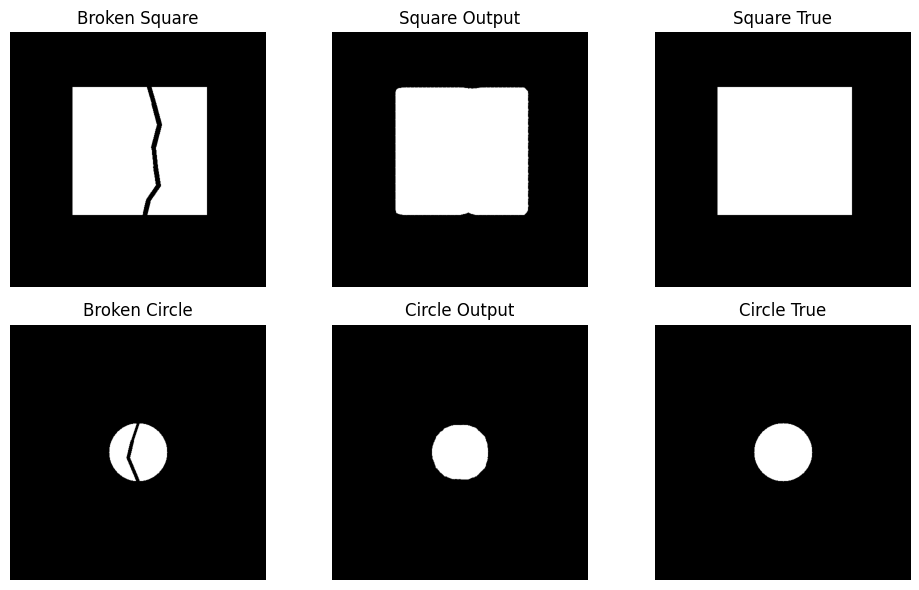

In [15]:
images = [broken_square_img, square_output_image, true_square, 
          broken_circle_image, circle_output_image, true_circle]

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Titles for the images
titles = ['Broken Square', 'Square Output', 'Square True',
          'Broken Circle', 'Circle Output', 'Circle True']

# Display each image in the respective subplot
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')  # Use cmap='gray' for grayscale images
    ax.set_title(titles[i])
    ax.axis('off')  # Optional: turn off axes for cleaner display

plt.tight_layout()
plt.show()

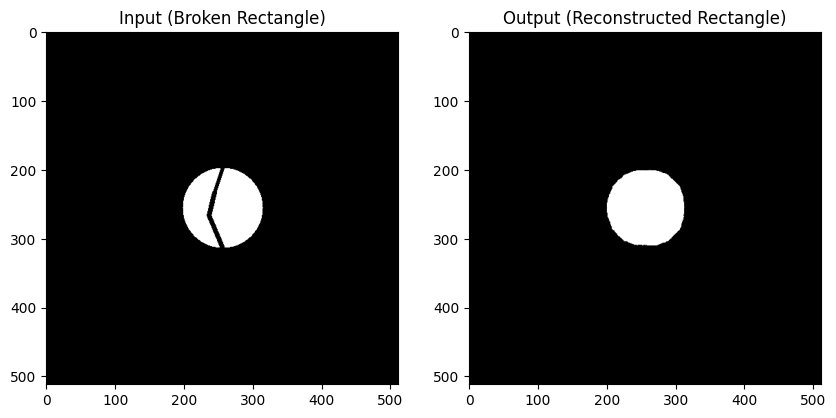

In [11]:
# Run inference on a test image
img_path = 'Data/test/circle_99_broken.png'
output_image = infer(model, img_path)

# Display input and output images side by side for comparison
input_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Input (Broken Rectangle)")
plt.imshow(input_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Output (Reconstructed Rectangle)")
plt.imshow(output_image, cmap='gray')

plt.show()

C:\Users\wesle\AppData\Local\Temp\ipykernel_34260\1922663555.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


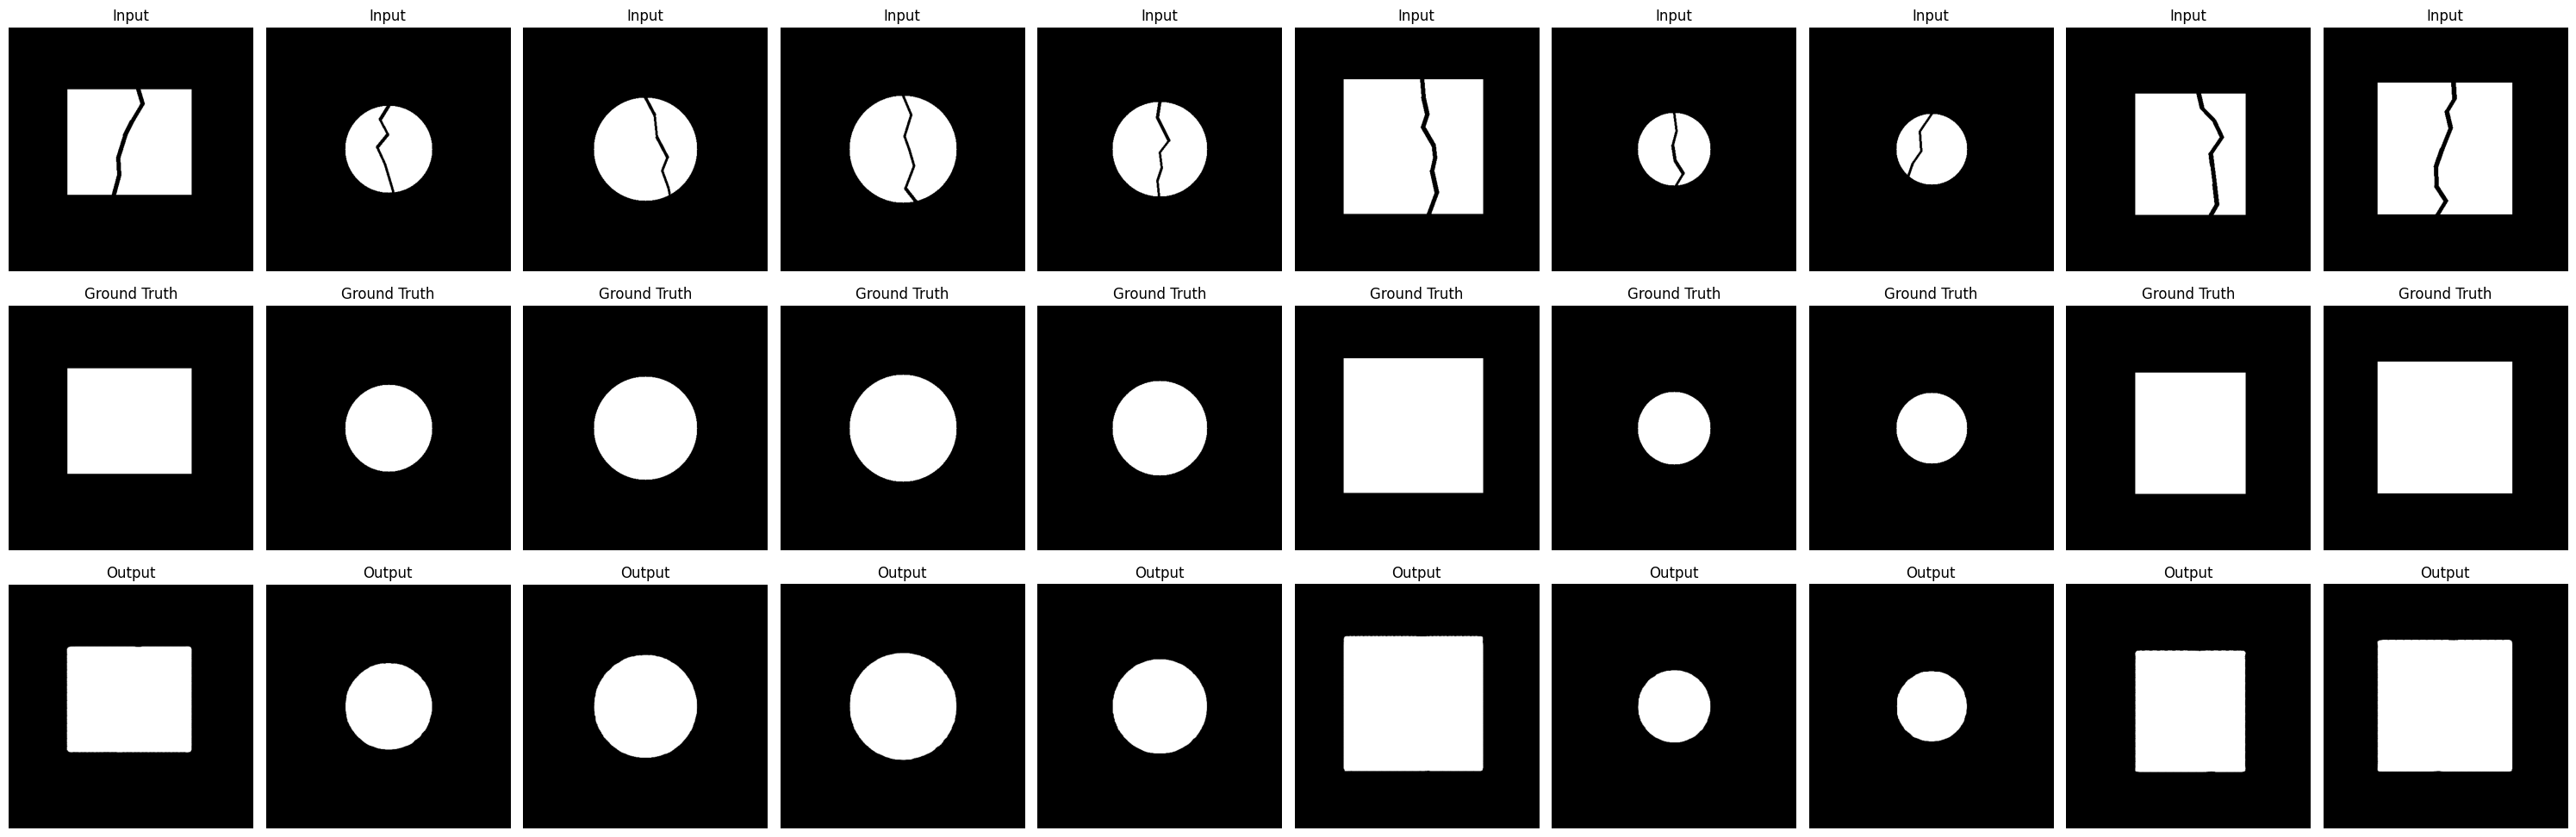

In [10]:
import random

# Run inference and plot predictions for 10 random images from the inference dataset
model.eval()  # Set the model to evaluation mode

# Get a list of indices for the inference dataset
infer_indices = list(range(len(infer_dataset)))

# Randomly select 10 indices
random_indices = random.sample(infer_indices, 10)

# Create a figure to hold the images
plt.figure(figsize=(30, 10))

for i, idx in enumerate(random_indices):
    # Get the input image, label (ground truth), and its corresponding output from the inference dataset
    input_image, label = infer_dataset[idx]
    input_image = input_image.unsqueeze(0).cuda()  # Add batch dimension and move to GPU
    label = label.unsqueeze(0).cuda()  # Add batch dimension for ground truth

    # Forward pass to get the reconstructed image
    with torch.no_grad():
        output_image = model(input_image)

    # Convert input, label, and output to numpy for visualization
    input_image_np = input_image.squeeze().cpu().numpy()
    label_np = label.squeeze().cpu().numpy()
    output_image_np = output_image.squeeze().cpu().numpy()

    # Denormalize the output image from [0, 1] to [0, 255]
    output_image_np = (output_image_np * 255).astype(np.uint8)

    # Plot the images
    plt.subplot(3, 10, i + 1)
    plt.title("Input")
    plt.imshow(input_image_np, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 10, i + 11)
    plt.title("Ground Truth")
    plt.imshow(label_np, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 10, i + 21)
    plt.title("Output")
    plt.imshow(output_image_np, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
